In [112]:
import os, math, subprocess
import datetime as dt

#data wrangling
import numpy as np
import pandas as pd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#excel library
import xlrd

#importing Statsmodels
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from scipy.stats import chisquare
#Scikitlearn libraries
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, chi2
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot, PredictionError, AlphaSelection


In [113]:
#Loading data
salary = pd.read_excel('salary features.xlsx')
salary.head()

,customer_id,first_name,txn_description,payment_count,payment_sum,payment_type,avg_income_past_3_months,annual_salary_after_tax,weekly_income,weekly_tax_withholding,annual_salary
0,CUS-3142625864,Ricky,PAY/SALARY,13,33644.13,Weekly,2588.01,134577,2588.99,905.8404,181731
1,CUS-2738291516,Kenneth,PAY/SALARY,13,33081.88,Weekly,2544.76,132328,2545.99,889.0704,178623
2,CUS-2155701614,Linda,PAY/SALARY,13,31762.12,Weekly,2443.24,127048,2443.99,849.2904,171251
3,CUS-2031327464,Michael,PAY/SALARY,13,29644.68,Weekly,2280.36,118579,2280.99,785.7204,159469
4,CUS-261674136,Kenneth,PAY/SALARY,7,30837.10,Fortnightly,4405.30,114538,2203.99,755.6904,153834


In [114]:
#Choose variables for input:
predict = salary
predict = predict.drop('customer_id',1)
predict = predict.drop('first_name',1)
predict = predict.drop('txn_description',1)
predict = predict.drop('payment_type',1)
predict.head()
#Features are 'payment_count','payment_sum','avg_income_past_3_months', 'annual_salary_after_tax', 'weekly_income', 'weekly_tax_withholding'

,payment_count,payment_sum,avg_income_past_3_months,annual_salary_after_tax,weekly_income,weekly_tax_withholding,annual_salary
0,13,33644.13,2588.01,134577,2588.99,905.8404,181731
1,13,33081.88,2544.76,132328,2545.99,889.0704,178623
2,13,31762.12,2443.24,127048,2443.99,849.2904,171251
3,13,29644.68,2280.36,118579,2280.99,785.7204,159469
4,7,30837.10,4405.30,114538,2203.99,755.6904,153834


In [115]:
X = predict.drop('annual_salary',1)   #Feature Matrix
y = predict['annual_salary']          #Target Variable
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print ('X training set:', X_train.shape,'Y training set:', y_train.shape)
print ('X testing set:', X_test.shape, 'Y testing set:', y_test.shape)
#Top: 50% training set of table contains 7 columns
#Bottom: 50% testing set of table contains 7 columns

X training set: (50, 6) Y training set: (50,)
X testing set: (50, 6) Y testing set: (50,)


# 1. Scikit-learn

# Model fitting & statistical checking

In [116]:
# fit a model
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions_test = lm.predict(X_test)
predictions_train = lm.predict(X_train)

print ('R squared_train:',lm.score(X_train, y_train))
print ('R squared_test:',lm.score(X_test, y_test))
print ('estimateIntercept:',lm.intercept_)
print ('no of cofficients:',len(lm.coef_))
# Print out the statistics

R squared_train: 0.9999220093352766
R squared_test: 0.9998827999739208
estimateIntercept: 2851.2779841091397
no of cofficients: 6


In [117]:
#print('estimate coefficient',lm.coef_ )
pd.DataFrame(zip(X_train.columns, lm.coef_), columns = ['Features','estimatedCoefficients'])

,Features,estimatedCoefficients
0,payment_count,-223.618151
1,payment_sum,0.006824
2,avg_income_past_3_months,-1.348130
3,annual_salary_after_tax,0.589837
4,weekly_income,20.769726
5,weekly_tax_withholding,58.221475


In [118]:
#RMSE
# Calculate the root mean square error (RMSE) for test and training data
N = len(y_test)
rmse_test = np.sqrt(np.sum((np.array(y_test).flatten() - np.array(predictions_test).flatten())**2)/N)
print("RMSE TEST: ", rmse_test)  

N = len(y_train)
rmse_train = np.sqrt(np.sum((np.array(y_train).flatten() - np.array(predictions_train).flatten())**2)/N)
print("RMSE TRAIN: ", rmse_train)  

RMSE TEST:  411.37077754554156
RMSE TRAIN:  363.9838668889685


In [119]:
#Chi Squared test
chi2_train, pval_train = chi2(X_train, y_train)
chi2_test, pval_test = chi2(X_test, y_test)
print ('Chi Square Train:',chi2_train)
print ('Chi Square Test:',chi2_test)
print ('P-Values Train',pval_train)
print ('P-Values Test',pval_test)

Chi Square Train: [7.79390756e+01 1.49305936e+05 5.73870490e+04 7.47216195e+05
 1.43061812e+04 5.85899192e+03]
Chi Square Test: [6.51130221e+01 1.19167662e+05 2.75805915e+04 6.02078497e+05
 1.15693878e+04 4.63839017e+03]
P-Values Train [0.00404627 0.         0.         0.         0.         0.        ]
P-Values Test [0.06142361 0.         0.         0.         0.         0.        ]


# Visualisation Checking

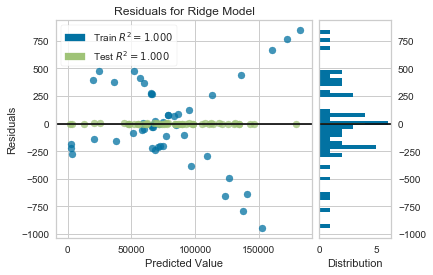

In [132]:
# Residual plot, check Rquare
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, predictions_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [121]:
#plot annual salary vs predicted annual salary
#plot predicted result
# Prediction Error Plot

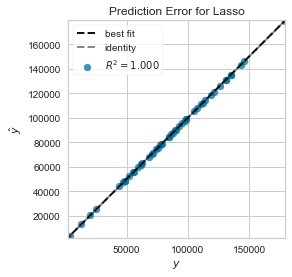

In [133]:
#Prediction Error Plot
# Instantiate the linear model and visualizer
lasso = Lasso()
visualizer1 = PredictionError(lasso)

visualizer1.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer1.score(X_test, predictions_test)  # Evaluate the model on the test data
g = visualizer1.poof()             # Draw/show/poof the data

C:\Users\My Computer\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


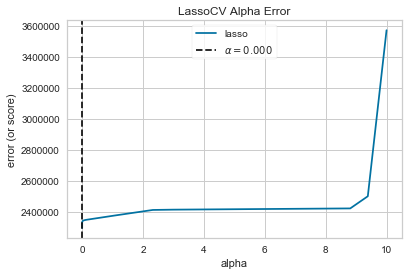

In [134]:
# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, predictions_test)
g = visualizer.poof()

# 2. Stats Model

1. Statistic checking

In [124]:
# Note the difference in argument order
model2 = sm.OLS(y_train, X_train).fit()
stat_testPredictions = model.predict(X_test) # make the predictions by the model
stat_trainPredictions = model.predict(X_train) # make the predictions by the model

# Print out the statistics
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          annual_salary   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.163e+05
Date:                Tue, 20 Aug 2019   Prob (F-statistic):           1.27e-96
Time:                        22:44:41   Log-Likelihood:                -383.11
No. Observations:                  50   AIC:                             778.2
Df Residuals:                      44   BIC:                             789.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
payment_count              -68.7459     33.921     -2.027      0.049    -137.110      -0.382
payment_sum                 -0.0390      0.039     -0.999      0.323      -0.118       0.040
avg_income_past_3_months    -0.9364      0.141     -6.619      0.000      -1.222      -0.651
annual_salary_after_tax      0.5309      0.158      3.363      0.002       0.213       0.849
weekly_income               29.9522      8.541      3.507      0.001      12.739      47.165
weekly_tax_withholding      42.0760      6.300      6.679      0.000      29.380      54.772
==============================================================================
Omnibus:                        0.740   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.691   Jarque-Bera (JB):                0.383
Skew:                           0.211   Prob(JB):                        0.826
Kurtosis:                       3.069   Cond. No.                     3.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2. Visualisation checking